# Prueba A/B del sistema de recomendaciones

El proyecto consiste en una prueba A/B realizada por una tienda en línea internacional para evaluar la efectividad de un nuevo sistema de recomendaciones. La prueba se llevó a cabo del 7 de diciembre de 2020 al 1 de enero de 2021, y se dividió a los participantes en dos grupos:

Grupo A (control): este grupo utilizó el sistema de recomendaciones existente.

Grupo B: este grupo utilizó el nuevo sistema de recomendaciones.

La prueba se realizó en la región de la UE y se incluyó al 15% de los nuevos usuarios.

### Instrucciones para completar la tarea

- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

## Objetivos

Realizar una prueba A/B para verificar si aumenta al menos un 10% en cada etapa del embudo de conversión __product_page → product_card → purchase__ dentro de los siguientes 14 días posteriores a la inscripción.


## Exploración de Datos

In [39]:
# Importación de librerías

import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns

In [20]:
# Carga de datos
project_mkt = pd.read_csv('final_ab_project_marketing_events_us.csv', sep=',')
new_users = pd.read_csv('final_ab_new_users_upd_us.csv', sep=',')
events = pd.read_csv('final_ab_events_upd_us.csv', sep=',')
participants = pd.read_csv('final_ab_participants_upd_us.csv', sep=',')

### Descripción de datasets
- `project_mkt`: el calendario de eventos de marketing para 2020
- `new_users`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `events`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `participants`: tabla con los datos de los participantes de la prueba


Se muestra la información preliminar de cada dataset

#### project_mkt
Estructura

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

In [21]:
display(project_mkt.head()) # mostrar el dataframe (5 primeros registros)
project_mkt.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', project_mkt.duplicated().sum() ) # verificar duplicados

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes

Duplicados: 0


 El data set no tiene datos ausentes, no tiene duplicados, los nombres de columna están en snake_case y se debe convertir el tipo de datos alusivo a fechas. 

In [22]:
project_mkt['start_dt'] = pd.to_datetime(project_mkt['start_dt']) # conversión a datetime
project_mkt['finish_dt'] = pd.to_datetime(project_mkt['finish_dt']) # conversión a datetime

# Obtener días transcurridos de la campaña
project_mkt['duration'] = (project_mkt['finish_dt'] - project_mkt['start_dt']).dt.days

#### new_users

Estructura:

- `user_id`: id de usuario
- `first_date`: fecha de inscripción
- `region`: localización
- `device`: dispositivo utilizado para la inscripción

In [23]:
display(new_users.head()) # mostrar el dataframe (5 primeros registros)
new_users.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', new_users.duplicated().sum() ) # verificar duplicados

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

Duplicados: 0


No existen datos ausentes, no hay duplicados y cumple nomneclatura snake_case. Se debe convertir el tipo de datos alusivo a fechas

In [24]:
new_users['first_date'] = pd.to_datetime(new_users['first_date']) # convertir a tipo fecha

#### events

Estructura

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

In [25]:
display(events.head()) # mostrar el dataframe (5 primeros registros)
events.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', events.duplicated().sum() ) # verificar duplicados

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

Duplicados: 0


No hay duplicados, cumple nomneclatura snake_case, pero existen datos ausentes en la columna details. Se debe convertir el tipo de datos alusivo a fechas.

In [26]:
events['event_dt'] = pd.to_datetime(events['event_dt']) # convertir a tipo fecha
print(events['details'].value_counts()) # inspeccionar los posibles valores de details.
print('details on:', events[~events['details'].isna()]['event_name'].unique()) #mostrar valores únicos de evento
print('event names:', events['event_name'].unique()) # Cuales son los valores posibles en event_name

details
4.99      44579
9.99       9158
99.99      5405
499.99     1172
Name: count, dtype: int64
details on: ['purchase']
event names: ['purchase' 'product_cart' 'product_page' 'login']


solamente existen valores de montos en 'details' cuando el evento se trata de una compra. para el resto de casos, reemplazar con 0 en referencia que no se compra en esa etapa.

In [35]:
events['details'] = events['details'].fillna(0) # reemplazar NaN con 0
events.info() # verificar reemplazo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     423761 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


#### participants

Estructura

- `user_id`: id del usuario
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [28]:
display(participants.head()) # mostrar el dataframe (5 primeros registros)
participants.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', participants.duplicated().sum() ) # verificar duplicados

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB

Duplicados: 0


No hay valores ausentes ni duplicados, cumple nomenclatura snake_case. Datos listos.

In [29]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.00
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00


In [30]:
print('No. Eventos:', events['event_name'].nunique()) # Cuantificar eventos
print('No. Usuario(a)s:', events['user_id'].nunique()) # Cuantificar usuarios
print('Promedio eventos/usuario:',round(events['event_name'].count()/events['user_id'].nunique(),2))

No. Eventos: 4
No. Usuario(a)s: 58703
Promedio eventos/usuario: 7.22


## Análisis Exploratorio

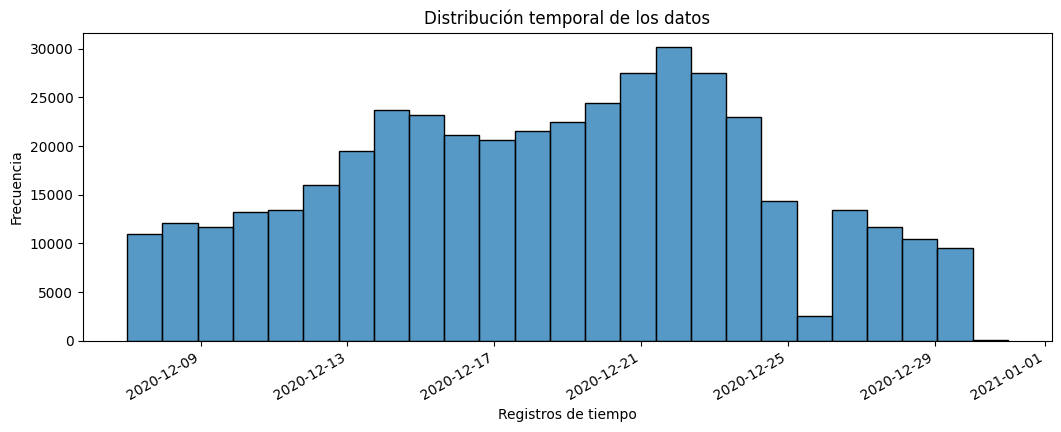

In [50]:
plt.figure(figsize=(12.5, 4))  # Tamaño personalizado

sns.histplot(events['event_dt'], bins=25) # histograma por fecha y hora

# Añadir etiquetas y título
plt.xlabel('Registros de tiempo')
plt.ylabel('Frecuencia')
plt.title('Distribución temporal de los datos')
plt.xticks(rotation=30, ha='right', fontsize=10)

plt.show() # Mostrar gráfico

Se observa una discontinuidad temporal de datos el 25 de diciembre, esto puede deberse a que la gente dejó de usar la aplicación para enfocarse en celebrar navidad y quiza se dio un descanso el día 26. De forma similar ocurrió después del 30 de diciembre. O talvez para esas fechas se agotó stock de ciertos productos.

### Embudo de conversión

In [36]:
events['event_name'].value_counts() # mostrar frecencia de los eventos.

event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64

In [37]:
# No. usuarios que realizan que pasan por eventos al menos 1 vez
events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False) 

event_name
login           58696
product_page    38929
purchase        19568
product_cart    19284
Name: user_id, dtype: int64

La etapa de login se omitirá para el embudo ya que el objetivo es analizar la conversión desde la página de producto, carrito de compras y realización de compra.

Nótese que hay menos usuarios en la etapa del carrito que en la confirmación de compras, esto puede deberse a que existen ciertos usuarios que no agregaron productos al carrito sino que los compraron inmediatamente desde alguna opción. Lo cual puede ser una buena señal de que la introducción del sistema de compras mejorado dio resultados. Sin embargo se puede segmentar a los clientes de los grupos A y B y observar sus embudos respectivos.

In [80]:
user_events = events.groupby('user_id')['event_name'].value_counts().reset_index()
user_events

,user_id,event_name,count
0,0001710F4DDB1D1B,login,2
1,0001710F4DDB1D1B,product_cart,2
2,0001710F4DDB1D1B,product_page,2
3,000199F1887AE5E6,login,4
4,000199F1887AE5E6,product_cart,4
...,...,...,...
136472,FFFAB034A09DCC28,login,2
136473,FFFAB034A09DCC28,product_page,2
136474,FFFFE36C0F6E92DF,login,3
136475,FFFFE36C0F6E92DF,product_cart,3


In [86]:
user_events_pivot = pd.pivot_table(data=events, values='event_dt', index='user_id', columns='event_name', aggfunc='count')

event_name,login,product_cart,product_page,purchase
user_id,,,,
0001710F4DDB1D1B,2.0,2.0,2.0,NaN
000199F1887AE5E6,4.0,4.0,4.0,4.0
0002499E372175C7,3.0,NaN,3.0,3.0
0002CE61FF2C4011,4.0,4.0,4.0,NaN
000456437D0EFFE1,2.0,NaN,2.0,NaN
...,...,...,...,...
FFF7A7BAF44FE9B4,2.0,NaN,NaN,NaN
FFF8FDBE2FE99C91,4.0,NaN,4.0,4.0
FFF91B6C5431F375,4.0,4.0,NaN,NaN


In [81]:

# obtener una pivot table para cuantificar etapas por usuario
user_events_pivot = pd.pivot_table(data=user_events, index='user_id', columns='event_name', aggfunc='sum')
user_events_pivot

count                                   
event_name       login product_cart product_page purchase
user_id                                                  
0001710F4DDB1D1B   2.0          2.0          2.0      NaN
000199F1887AE5E6   4.0          4.0          4.0      4.0
0002499E372175C7   3.0          NaN          3.0      3.0
0002CE61FF2C4011   4.0          4.0          4.0      NaN
000456437D0EFFE1   2.0          NaN          2.0      NaN
...                ...          ...          ...      ...
FFF7A7BAF44FE9B4   2.0          NaN          NaN      NaN
FFF8FDBE2FE99C91   4.0          NaN          4.0      4.0
FFF91B6C5431F375   4.0          4.0          NaN      NaN
FFFAB034A09DCC28   2.0          NaN          2.0      NaN
FFFFE36C0F6E92DF   3.0          3.0          3.0      NaN

[58703 rows x 4 columns]

In [57]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.00
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00


In [55]:
# Verificar si hay compras de 0 dólares
events[(events['event_name']=='purchase') & (events['details']==0.00)].size

0

No hay compras de 0.00

## Test A/B

## Conclusiones